In [35]:
import sys
from pathlib import Path
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix, classification_report

import pandas as pd
from pathlib import Path
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [36]:
# Add the src directory to the Python path
sys.path.append(str(Path().resolve().parent))

# Now you can import the clean_data function
from src.data_cleaning import drop_columns, impute_missing_values
from src.data_preprocessing import preprocess_data
from src.logging_utils import configure_logging

data = pd.read_csv("../input/train_folds.csv")
df = drop_columns(data)

In [37]:


# for fold in range(5):

fold = 1
fold_df = impute_missing_values(df, fold)
fold_df = impute_missing_values(df, 0)
fold_df = preprocess_data(fold_df, fold=0)
# drop the kfold column
fold_df = fold_df.drop("kfold", axis=1)

# Split the data into X and y
X = fold_df.drop("Converted", axis=1)
y = fold_df["Converted"]
# Split the data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the logistic regression model
log_reg = LogisticRegression()
rfe = RFE(log_reg, n_features_to_select=11)
rfe.fit(X_train, y_train)

# Extract the ranking of the features
ranking = pd.Series(rfe.ranking_, index=X_train.columns)
print(f"Feature ranking: \n{ranking.sort_index()}")

# Continue with the model trained on the selected features
selected_features = X_train.columns[rfe.support_]
print(f"Selected features: {selected_features}")
log_reg.fit(X_train[selected_features], y_train)

# Make predictions
y_pred = log_reg.predict(X_test[selected_features])
y_pred_proba = log_reg.predict_proba(X_test[selected_features])[:, 1] # Probability of being 1

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")

Feature ranking: 
A free copy of Mastering The Interview    53
Digital Advertisement                     23
Do Not Call                               29
Do Not Email                               1
Last Activity_Converted to Lead            1
                                          ..
Search                                    34
Through Recommendations                   10
Total Time Spent on Website                1
TotalVisits                               47
X Education Forums                        46
Length: 67, dtype: int64
Selected features: Index(['Do Not Email', 'Total Time Spent on Website',
       'Lead Origin_Lead Add Form', 'Lead Source_Olark Chat',
       'Lead Source_Welingak Website', 'Last Activity_Converted to Lead',
       'Last Activity_Had a Phone Conversation',
       'Last Activity_Olark Chat Conversation',
       'Last Notable Activity_Had a Phone Conversation',
       'Last Notable Activity_SMS Sent', 'Last Notable Activity_Unreachable'],
      dtype='object'

In [38]:
def calculate_vif(dataframe):
    """
    Calculates the Variance Inflation Factor (VIF) for each feature in a given DataFrame.
    Parameters:
    - dataframe: A pandas DataFrame containing only the feature variables (numeric).
    Returns:
    - A pandas DataFrame with two columns: 'Feature' and 'VIF', indicating the VIF for each feature.
    """
    # Adding a constant to include the intercept in the VIF calculation
    df_with_constant = add_constant(dataframe)
    # Initializing the DataFrame to store VIF values
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df_with_constant.columns
    # Calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(df_with_constant.values, i) for i in range(df_with_constant.shape[1])]
    return vif_data

In [39]:
vif_dataframe = calculate_vif(fold_df[selected_features])
print(vif_dataframe)

                                           Feature       VIF
0                                            const  2.171984
1                                     Do Not Email  1.019810
2                      Total Time Spent on Website  1.250886
3                        Lead Origin_Lead Add Form  1.314201
4                           Lead Source_Olark Chat  1.442906
5                     Lead Source_Welingak Website  1.229586
6                  Last Activity_Converted to Lead  1.050732
7           Last Activity_Had a Phone Conversation  1.880260
8            Last Activity_Olark Chat Conversation  1.267395
9   Last Notable Activity_Had a Phone Conversation  1.876032
10                  Last Notable Activity_SMS Sent  1.080171
11               Last Notable Activity_Unreachable  1.002601


Best F1-Score threshold: 0.3518018018018018, Best F1-Score: 0.7447368421052631
Best Accuracy threshold: 0.4528828828828829, Best Accuracy: 0.801948051948052
Best Precision threshold: 0.9840540540540541, Best Precision: 1.0
Best Recall threshold: 0.0, Best Recall: 1.0
Best threshold (Recall ≈ Precision): 0.4608108108108108


<Figure size 1500x1000 with 0 Axes>

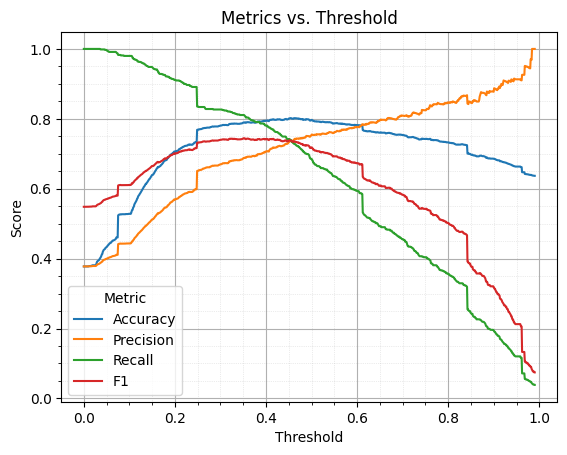

In [40]:
import numpy as np

def evaluate_thresholds(probs, y_test, thresholds=np.linspace(0, 0.99, 1000), tol=0.01):
    metrics = []
    best_f1, best_accuracy, best_precision, best_recall = 0, 0, 0, 0
    best_f1_threshold, best_accuracy_threshold, best_precision_threshold, best_recall_threshold = 0, 0, 0, 0
    best_threshold = 0.1

    for threshold in thresholds:
        y_pred = (probs >= threshold).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        metrics.append([threshold, accuracy, precision, recall, f1])
        
        if f1 > best_f1:
            best_f1 = f1
            best_f1_threshold = threshold
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_accuracy_threshold = threshold
        if precision > best_precision:
            best_precision = precision
            best_precision_threshold = threshold
        if recall > best_recall:
            best_recall = recall
            best_recall_threshold = threshold
        if abs(recall - precision) <= tol:  # Compare within the tolerance
            best_threshold = threshold

    metrics_df = pd.DataFrame(metrics, columns=["Threshold", "Accuracy", "Precision", "Recall", "F1"])
    metrics_df = metrics_df.set_index("Threshold")

    print(f"Best F1-Score threshold: {best_f1_threshold}, Best F1-Score: {best_f1}")
    print(f"Best Accuracy threshold: {best_accuracy_threshold}, Best Accuracy: {best_accuracy}")
    print(f"Best Precision threshold: {best_precision_threshold}, Best Precision: {best_precision}")
    print(f"Best Recall threshold: {best_recall_threshold}, Best Recall: {best_recall}")
    print(f"Best threshold (Recall ≈ Precision): {best_threshold}")

    return metrics_df, best_f1_threshold, best_accuracy_threshold, best_precision_threshold, best_recall_threshold, best_threshold


def plot_metrics(metrics_df):
    plt.figure(figsize=(15, 10))
    metrics_df.plot()
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Metrics vs. Threshold")
    plt.legend(title="Metric")
    plt.grid(True, which='both')
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray', alpha=0.3)

    plt.show()

# Example usage:

metrics_df, best_f1_threshold, best_accuracy_threshold, best_precision_threshold, best_recall_threshold, best_threshold = evaluate_thresholds(y_pred_proba, y_test)
plot_metrics(metrics_df)

In [41]:
# List of thresholds to evaluate
thresholds = np.linspace(0.30, 0.70, 40)

for chosen_threshold in thresholds:
    # Apply the threshold to get predictions
    y_pred = (y_pred_proba >= chosen_threshold).astype(int)

    # Calculate the metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print(f"Threshold {chosen_threshold:.2f}: Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}, AUC: {auc_score:.2f}")

Threshold 0.30: Accuracy: 0.78, Precision: 0.67, Recall: 0.83, F1-Score: 0.74, AUC: 0.86
Threshold 0.31: Accuracy: 0.78, Precision: 0.67, Recall: 0.82, F1-Score: 0.74, AUC: 0.86
Threshold 0.32: Accuracy: 0.79, Precision: 0.68, Recall: 0.82, F1-Score: 0.74, AUC: 0.86
Threshold 0.33: Accuracy: 0.79, Precision: 0.68, Recall: 0.82, F1-Score: 0.74, AUC: 0.86
Threshold 0.34: Accuracy: 0.79, Precision: 0.68, Recall: 0.81, F1-Score: 0.74, AUC: 0.86
Threshold 0.35: Accuracy: 0.79, Precision: 0.69, Recall: 0.81, F1-Score: 0.74, AUC: 0.86
Threshold 0.36: Accuracy: 0.79, Precision: 0.69, Recall: 0.80, F1-Score: 0.74, AUC: 0.86
Threshold 0.37: Accuracy: 0.79, Precision: 0.69, Recall: 0.80, F1-Score: 0.74, AUC: 0.86
Threshold 0.38: Accuracy: 0.79, Precision: 0.70, Recall: 0.79, F1-Score: 0.74, AUC: 0.86
Threshold 0.39: Accuracy: 0.79, Precision: 0.70, Recall: 0.79, F1-Score: 0.74, AUC: 0.86
Threshold 0.40: Accuracy: 0.79, Precision: 0.71, Recall: 0.78, F1-Score: 0.74, AUC: 0.86
Threshold 0.41: Accur